In [5]:
import pandas as pd 
import json 
import copy
import re 
from collections import Counter, defaultdict

pd.set_option('display.max_columns',100)
pd.set_option('display.max_colwidth',500)

In [27]:
!ls ../cache/bert-large-uncased/lm_diagnostic_extended/singular/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_5_anchor_scorer_probAvg.csv

../cache/bert-large-uncased/lm_diagnostic_extended/singular/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_5_anchor_scorer_probAvg.csv


In [83]:
path1 = '../cache/bert-large-uncased/lm_diagnostic_extended/singular/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_5_anchor_scorer_probAvg.csv'
path2 = '../cache/bert-large-uncased/lm_diagnostic_extended/plural/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_5_anchor_scorer_probAvg.csv'


dfs = pd.read_csv(path1)
dfp = pd.read_csv(path2)
display(dfs[['sub_label', 'subj_anchors']].head())
display(dfp[['sub_label', 'subj_anchors']].head())
# metrics = ['sub_label', 'obj_label', 'p1_sentence', 'p1_def_sap', 'p1_lsp_sap', 'p1_sentence_dap', 'p1_def_dap', 'p1_lsp_dap']

# df_merge  = pd.merge(dfs, dfp,on= 'uuid', suffixes=('_singular', '_plural'))
# # display(df_merge)

# dfs = dfs[metrics]
# dfp = dfp[metrics]
# for col in metrics[2:]:
#     df_merge[col] = df_merge[[f"{col}_singular", f"{col}_plural"]].apply(lambda x: 1 if x[0]==1 and x[1]==1 else 0 , axis=1)

# print("-"*80)
# # display(df_merge)
# print("-"*40, "singular", "-"*40)
# dfs_mean = dfs[metrics[2:]].mean().to_frame().round(3)*100
# display(dfs_mean.T)

# print("-"*40, "plural", "-"*40)
# dfp_mean = dfp[metrics[2:]].mean().to_frame().round(3)*100
# display(dfp_mean.T)


# df_mean = df_merge[metrics[2:]].mean().to_frame().round(3)*100
# display(df_mean.T)

,sub_label,subj_anchors
0,graver,"['shovel', 'digger', 'deeper', 'grave', 'hammer']"
1,smallmouth,"['bass', 'catfish', 'carp', 'cisco', 'trout']"
2,pelican,"['dolphin', 'whale', 'bird', 'heron', 'duck']"
3,sapsucker,"['demon', 'snake', 'vampire', 'rat', 'insect']"
4,mako,"['human', 'dog', 'bird', 'man', 'animal']"


,sub_label,subj_anchors
0,gravers,"['tombs', 'graves', 'murderers', 'yes', 'buria..."
1,smallmouths,"['catfish', 'carp', 'cerambycidae', 'snails', ..."
2,pelicans,"['dolphins', 'ducks', 'whales', 'turtles', 'bi..."
3,sapsuckers,"['snakes', 'spiders', 'lizards', 'vampires', '..."
4,makoes,"['human', 'tribe', 'slaves', 'man', 'peter']"


# Analyis

1. Where do the gains come from? 

In [48]:
def get_freq_level_from_SUBTLEX(subtlex_path = "../data/SUBTLEX.US.POS.csv"):
    def bin_count(df, freq_col):
        cut_labels = ["LOW", "MEDIUM", "FREQUENT"] #, "VERYFREQUENT"]
        cut_bins = [0, 10, 100,  df[freq_col].max()] #5000,
        df['freq_level'] = pd.cut(df[freq_col], bins=cut_bins, labels=cut_labels).values.add_categories("UNSEEN")
        df['freq_level'].fillna(value='UNSEEN', inplace=True)
        return df

    df_freq = pd.read_csv(subtlex_path, sep='\t')
    df_freq = df_freq.dropna().reset_index()
    df_freq = df_freq[['Word', 'FREQcount']]
    df_freq = bin_count(df_freq,'FREQcount' )

    return df_freq

def get_word_to_freq ():
    df_freq = get_freq_level_from_SUBTLEX()
    word_to_freq_count = dict(zip(df_freq['Word'], df_freq['FREQcount']))
    word_to_freq_level = dict(zip(df_freq['Word'], df_freq['freq_level']))
    return word_to_freq_count, word_to_freq_level

word_to_freq_count, word_to_freq_level = get_word_to_freq()



In [60]:
from collections import defaultdict
import pandas as pd
from matplotlib import pyplot as plt

data_dir = '../cache/bert-large-uncased/lm_diagnostic_extended/consistency/'
files = ['IsA.def_sap.csv',  'IsA.def_dap.csv',  'IsA.lsp_sap.csv',  'IsA.lsp_dap.csv' ]
dfs_dic = defaultdict()


for file in files:
    path = data_dir + file 
    df = pd.read_csv(path)
    df['sub_label_singular_freq_level'] = df['sub_label_singular'].apply(lambda x: word_to_freq_level.get(x, 'UNSEEN')) 
    df['sub_label_plural_freq_level'] = df['sub_label_plural'].apply(lambda x: word_to_freq_level.get(x, 'UNSEEN')) 

    dfs_dic[f'{file.replace(".csv", "").replace("IsA.", "")}'] = df 
    


In [81]:
# display(dfs_dic['def_sap'].query("p1_pl==0")[['sub_label_singular_freq_level', 'sub_label_plural_freq_level']].value_counts().plot(kind='bar'))

display(dfs_dic['def_sap'].query("p1_sgpl==0")['sub_label_plural_freq_level'].value_counts())
display(dfs_dic['def_dap'].query("p1_sgpl==0")['sub_label_plural_freq_level'].value_counts())
display(dfs_dic['lsp_sap'].query("p1_sgpl==0")['sub_label_plural_freq_level'].value_counts())
display(dfs_dic['lsp_dap'].query("p1_sgpl==0")['sub_label_plural_freq_level'].value_counts())

UNSEEN      212
LOW          53
MEDIUM       18
FREQUENT      4
Name: sub_label_plural_freq_level, dtype: int64

UNSEEN      214
LOW          48
MEDIUM       11
FREQUENT      1
Name: sub_label_plural_freq_level, dtype: int64

UNSEEN      268
LOW          69
MEDIUM       22
FREQUENT      5
Name: sub_label_plural_freq_level, dtype: int64

UNSEEN      223
LOW          45
MEDIUM        9
FREQUENT      2
Name: sub_label_plural_freq_level, dtype: int64

Freq level of plural sub_label:



<ipython-input-64-fc751f99ef4c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hit_plurals_dap['obj_mask_sentence_pl_sap'] = hit_plurals_dap['sub_label_plural'].apply(lambda x: dfs_dic['def_sap'].query(f"sub_label_plural == '{x}'")['obj_mask_sentence_pl'].values[0] )


<AxesSubplot:title={'center':'Plural sub_label'}>

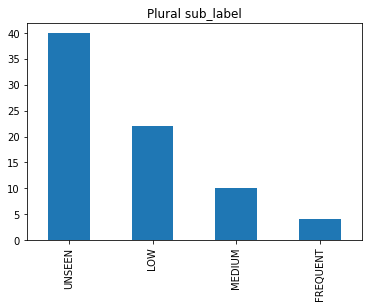

Freq level of singular sub_label:



<AxesSubplot:title={'center':'Singular sub_label'}>

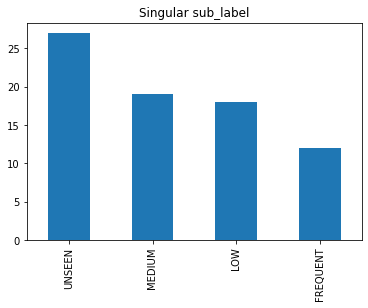

,sub_label_plural,obj_label_plural,obj_mask_sentence_pl,obj_mask_sentence_pl_sap,subj_anchors_plural,sub_label_plural_freq_level
36,vandas,flowers,['flowers'],['birds'],"['etc', 'human', 'indian', 'peter', 'paul']",UNSEEN
54,whaleboats,vehicles,['vehicles'],['fish'],"['ferries', 'boats', 'ships', 'barges', 'tugs']",UNSEEN
110,steakhouses,buildings,['buildings'],['fish'],"['restaurants', 'bars', 'pubs', 'yes', 'cafes']",UNSEEN
123,coracles,vehicles,['vehicles'],['fish'],"['ship', 'cannon', 'horses', 'yes', 'ships']",UNSEEN
157,chungas,birds,['birds'],['fish'],"['california', 'mexico', 'fish', 'philippines'...",UNSEEN
168,todies,birds,['birds'],['trees'],"['dog', 'deer', 'fish', 'pig', 'horse']",UNSEEN
177,cotingas,birds,['birds'],['trees'],"['brazil', 'portugal', 'human', 'fish', 'bahia']",UNSEEN
184,capelins,fish,['fish'],['birds'],"['dolphins', 'seals', 'cod', 'rabbits', 'fish']",UNSEEN
203,hardtops,vehicles,['vehicles'],['tools'],"['wagons', 'cabinets', 'cars', 'car', 'trucks']",UNSEEN
210,sawflies,insects,['insects'],['birds'],"['beetles', 'flies', 'butterflies', 'yes', 'ba...",UNSEEN


In [64]:
df_def_sap_pl_fail = dfs_dic['def_sap'].query("p1_pl==0")
# [['sub_label_plural', 'obj_label_plural', 'obj_mask_sentence_pl']]
missed_plurals_sap = df_def_sap_pl_fail['sub_label_plural'].to_list()

hit_plurals_dap = dfs_dic['def_dap'].query(f"sub_label_plural in {missed_plurals_sap} and p1_pl==1")

hit_plurals_dap['obj_mask_sentence_pl_sap'] = hit_plurals_dap['sub_label_plural'].apply(lambda x: dfs_dic['def_sap'].query(f"sub_label_plural == '{x}'")['obj_mask_sentence_pl'].values[0] )
# hit_plurals_dap_sub = hit_plurals_dap['sub_label_plural'].to_list()


print("Freq level of plural sub_label:\n",)
display(hit_plurals_dap['sub_label_plural_freq_level'].value_counts().plot(kind='bar', title='Plural sub_label'))
plt.show()
print("Freq level of singular sub_label:\n")
display(hit_plurals_dap['sub_label_singular_freq_level'].value_counts().plot(kind='bar',title='Singular sub_label'))
plt.show()

hit_plurals_dap[['sub_label_plural', 'obj_label_plural', 'obj_mask_sentence_pl', 'obj_mask_sentence_pl_sap', 'subj_anchors_plural', 'sub_label_plural_freq_level']].query("sub_label_plural_freq_level=='UNSEEN'").head(50)

In [68]:

 
hit_plurals_dap.query("sub_label_singular_freq_level == 'FREQUENT' and 'sub_label_plural_freq_level'!='FREQUENT'")[['sub_label_singular', 'sub_label_singular_freq_level', 'sub_label_plural', 'sub_label_plural_freq_level']]


,sub_label_singular,sub_label_singular_freq_level,sub_label_plural,sub_label_plural_freq_level
60,yacht,FREQUENT,yachts,MEDIUM
77,restaurant,FREQUENT,restaurants,FREQUENT
111,shed,FREQUENT,sheds,MEDIUM
227,consulate,FREQUENT,consulates,LOW
249,ship,FREQUENT,ships,FREQUENT
287,rink,FREQUENT,rinks,LOW
314,kirk,FREQUENT,kirks,LOW
387,cockroach,FREQUENT,cockroaches,FREQUENT
399,morgue,FREQUENT,morgues,MEDIUM
413,chateau,FREQUENT,chateaux,LOW
